In [1]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd
from skimage.segmentation import slic, mark_boundaries
import matplotlib.pyplot as plt
from rasterstats import zonal_stats

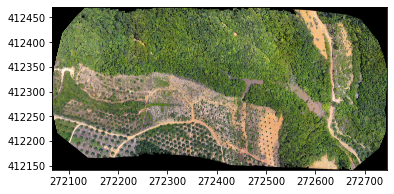

<AxesSubplot:>

In [2]:
image = rasterio.open('UAV_orthophoto (3).tif')
show(image)

In [3]:
AOI = gpd.read_file('AOI.shp')
shape = AOI.geometry

In [4]:
with rasterio.open("UAV_orthophoto (3).tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shape, crop=True)
    out_meta = src.meta


out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("image_new.tif", "w", **out_meta) as image:
    image.write(out_image)

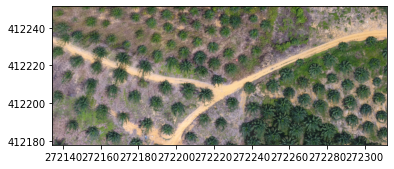

In [5]:
image = rasterio.open('image_new.tif')
show(image)
img = image.read([1,2,3])

In [6]:
img.shape

(3, 1433, 3465)

In [7]:
img = img.transpose(1,2,0)

In [8]:
img.shape

(1433, 3465, 3)

In [9]:
segments = slic(img, n_segments=1000, compactness=30, multichannel=True, start_label=1)

In [10]:
segments.shape

(1433, 3465)

In [11]:
segments

array([[  1,   1,   1, ...,  47,  47,  47],
       [  1,   1,   1, ...,  47,  47,  47],
       [  1,   1,   1, ...,  47,  47,  47],
       ...,
       [922, 922, 922, ..., 937, 937, 937],
       [922, 922, 922, ..., 937, 937, 937],
       [922, 922, 922, ..., 937, 937, 937]])

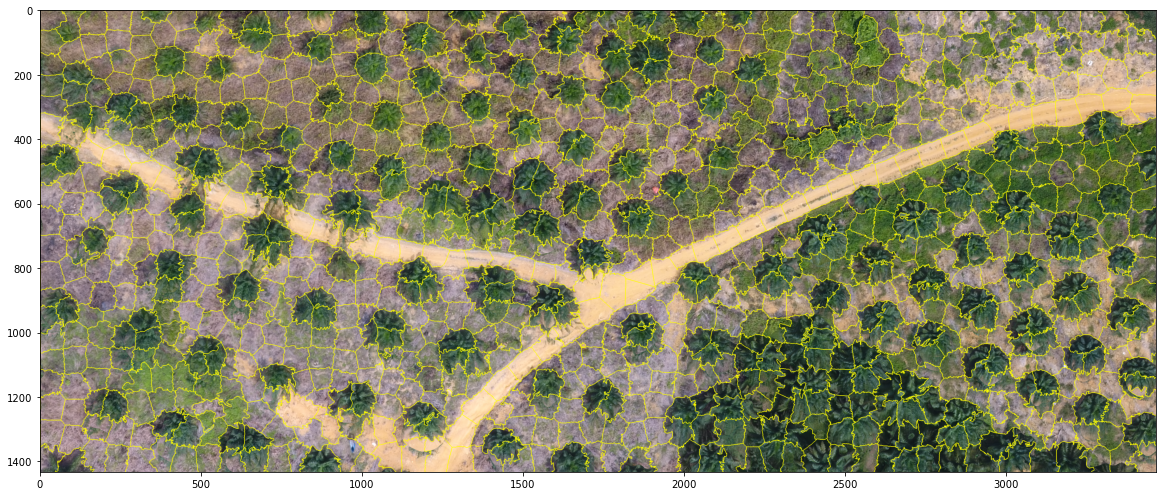

In [12]:
plt.figure(figsize = (20,10))
plt.imshow(mark_boundaries(img, segments))

In [13]:
img_seg = mark_boundaries(img, segments)


In [14]:
img_seg = img_seg.transpose(2,0,1)

In [15]:
img_seg.shape

(3, 1433, 3465)

In [16]:
type(segments)

numpy.ndarray

In [17]:
#save as .tif

with rasterio.open('image_new.tif') as src_dataset:

    profile = src_dataset.profile

    profile.update(
        count=1,
        compress='lzw')

    with rasterio.open('segments.tif', 'w', **profile) as dst:
        dst.write(segments, 1)

In [18]:
segments.shape

(1433, 3465)

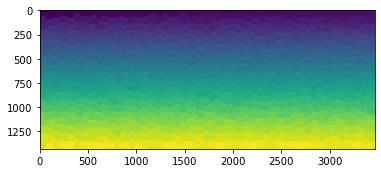

<AxesSubplot:>

In [19]:
show(segments)

In [20]:
!gdal_polygonize.py segments.tif segments.shp

0...10...20...30...40...50...60...70...80...90...100 - done.


In [21]:
segments_shp = gpd.read_file('segments.shp')
segments_shp

,DN,geometry
0,5,"POLYGON ((272150.701 412251.334, 272155.516 41..."
1,17,"POLYGON ((272200.180 412251.334, 272205.660 41..."
2,19,"POLYGON ((272210.578 412251.334, 272218.824 41..."
3,15,"POLYGON ((272192.138 412251.334, 272196.799 41..."
4,25,"POLYGON ((272241.207 412251.334, 272247.968 41..."
...,...,...
946,141,"POLYGON ((272174.980 412183.980, 272175.082 41..."
947,161,"POLYGON ((272219.080 412182.853, 272219.234 41..."
948,164,"POLYGON ((272237.366 412182.802, 272237.570 41..."
949,159,"POLYGON ((272268.302 412182.904, 272268.610 41..."


In [22]:
stats = zonal_stats('segments.shp', 'image_new.tif')
stats[1]

/home/dom/miniconda3/envs/obia/lib/python3.9/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


{'min': 15.0, 'max': 125.0, 'mean': 67.75344563552834, 'count': 4571}

In [23]:
stat_mean = []
for stat in stats:
    stat_mean.append(stat['mean'])

segments_shp['mean_brightness'] = stat_mean

In [24]:
#classfiy by brightness
class_list = []

for value in segments_shp['mean_brightness']:
    if value <= 45:
        class_list.append('shadow')
    if 45 < value < 90:
        class_list.append('trees')
    if value >= 90:
        class_list.append('backround')
        
segments_shp['class'] = class_list


In [29]:
#dissolve segemnts based on class
dissolve = segments_shp.dissolve('class')

In [53]:
dissolve.reset_index(inplace=True)
dissolve = dissolve.explode()

In [54]:
# save new shp file 
dissolve.to_file('dissolve.shp')

In [55]:
stats = zonal_stats('dissolve.shp', 'image_new.tif')
stats[1]

/home/dom/miniconda3/envs/obia/lib/python3.9/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


{'min': 18.0, 'max': 150.0, 'mean': 92.20622299049265, 'count': 5785}

In [56]:
stat_mean = []
for stat in stats:
    stat_mean.append(stat['mean'])

dissolve['mean_brightness'] = stat_mean

In [57]:
dissolve

index      class  DN  mean_brightness  \
0 0       0  backround   5       146.180428   
  1       0  backround   5        92.206223   
  2       0  backround   5       149.358798   
  3       0  backround   5        94.346621   
1 0       1     shadow  96        37.688073   
...     ...        ...  ..              ...   
2 85      2      trees  17        80.911845   
  86      2      trees  17        80.607486   
  87      2      trees  17        72.901761   
  88      2      trees  17        68.708384   
  89      2      trees  17        74.855554   

                                               geometry  
0 0   POLYGON ((272177.541 412181.419, 272177.489 41...  
  1   POLYGON ((272267.227 412182.648, 272267.432 41...  
  2   POLYGON ((272310.098 412182.648, 272310.047 41...  
  3   POLYGON ((272300.981 412226.493, 272301.083 41...  
1 0   POLYGON ((272259.902 412183.929, 272259.902 41...  
...                                                 ...  
2 85  POLYGON ((272270.146 412236.429, 272270.146 41...  
  86  POLYGON ((272265.741 412250.259, 272265.741 41...  
  87  POLYGON ((272249.556 412240.783, 272249.607 41...  
  88  POLYGON ((272241.361 412247.032, 272241.361 41...  
  89  POLYGON ((272311.788 412246.673, 272311.788 41...  

[109 rows x 5 columns]

<AxesSubplot:>

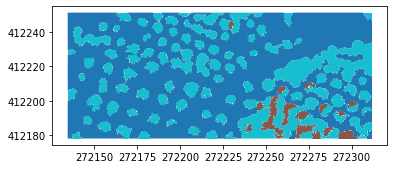

In [48]:
dissolve.plot('class')

In [58]:
dissolve['area'] = dissolve['geometry'].area
dissolve['perim'] = dissolve['geometry'].length

def PP_compactness():   # https://en.wikipedia.org/wiki/Polsby%E2%80%93Popper_test
    area = dissolve['area']
    perim = dissolve['perim']
    pi = 3.14159
    return (4*pi)* area / perim **2

dissolve['compactness'] = PP_compactness()

In [62]:
dissolve['compactness'].describe()

count    109.000000
mean       0.118496
std        0.053200
min        0.003042
25%        0.082063
50%        0.117978
75%        0.155892
max        0.239420
Name: compactness, dtype: float64

In [63]:

dissolve = dissolve[dissolve['compactness'] > 0.08]

<AxesSubplot:>

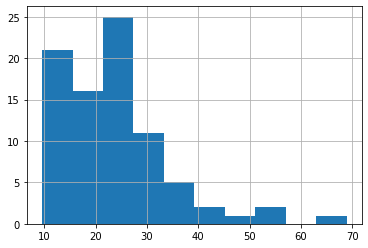

In [67]:
dissolve['area'].hist()

In [68]:
dissolve = dissolve[dissolve['area'] < 60]

<AxesSubplot:>

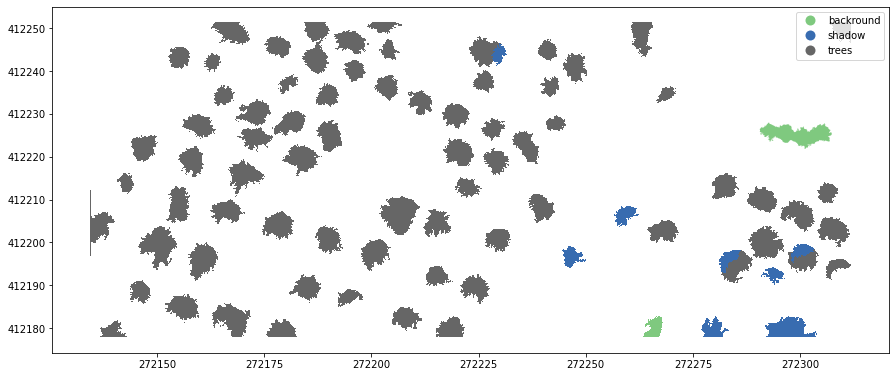

In [69]:
dissolve.plot('class', legend=True, figsize=(15,15), cmap='Accent')


In [71]:
canopy_trees = dissolve[dissolve['class'] == 'trees']

In [76]:
canopy_trees['area'].describe()

count    73.000000
mean     24.148672
std       8.747336
min       9.612461
25%      17.149744
50%      25.442591
75%      28.115925
max      53.188604
Name: area, dtype: float64

<AxesSubplot:>

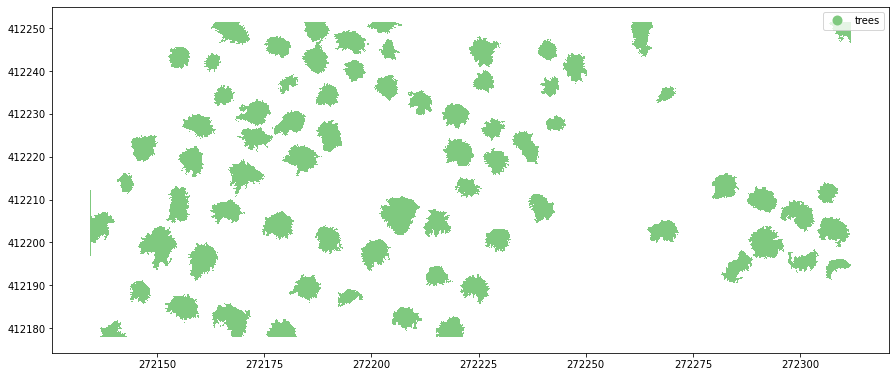

In [75]:
canopy_trees.plot('class', legend=True, figsize=(15,15), cmap='Accent')

In [82]:
def get_age(area):
    return 0.59 + 0.15 * area 

age = []

for tree in canopy_trees['area']:
    age.append(get_age(tree))

canopy_trees['age'] = age
canopy_trees


/home/dom/miniconda3/envs/obia/lib/python3.9/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


index  class  DN  mean_brightness  \
2 3       2  trees  17        57.921281   
  4       2  trees  17        68.828423   
  5       2  trees  17        63.602475   
  6       2  trees  17        73.716097   
  7       2  trees  17        61.665846   
...     ...    ...  ..              ...   
  85      2  trees  17        80.911845   
  86      2  trees  17        80.607486   
  87      2  trees  17        72.901761   
  88      2  trees  17        68.708384   
  89      2  trees  17        74.855554   

                                               geometry       area     perim  \
2 3   POLYGON ((272219.848 412182.597, 272220.104 41...  23.595655  38.10768   
  4   POLYGON ((272209.656 412183.878, 272209.707 41...  23.684853  44.35652   
  5   POLYGON ((272225.739 412191.458, 272225.790 41...  26.714982  58.90300   
  6   POLYGON ((272194.955 412189.153, 272195.058 41...  13.657881  38.21012   
  7   POLYGON ((272203.253 412196.580, 272203.253 41...  30.902070  56.23956   
...                                                 ...        ...       ...   
  85  POLYGON ((272270.146 412236.429, 272270.146 41...   9.612461  29.50272   
  86  POLYGON ((272265.741 412250.259, 272265.741 41...  26.775323  48.45412   
  87  POLYGON ((272249.556 412240.783, 272249.607 41...  24.729002  51.32244   
  88  POLYGON ((272241.361 412247.032, 272241.361 41...  15.050953  29.70760   
  89  POLYGON ((272311.788 412246.673, 272311.788 41...  14.856815  35.95644   

      compactness       age  
2 3      0.204182  4.129348  
  4      0.151274  4.142728  
  5      0.096759  4.597247  
  6      0.117554  2.638682  
  7      0.122776  5.225310  
...           ...       ...  
  85     0.138778  2.031869  
  86     0.143312  4.606298  
  87     0.117978  4.299350  
  88     0.214308  2.847643  
  89     0.144405  2.818522  

[73 rows x 9 columns]

In [117]:
canopy_trees[['age', 'area']].describe()

,age,area
count,73.000000,73.000000
mean,4.212301,24.148672
std,1.312100,8.747336
min,2.031869,9.612461
25%,3.162462,17.149744
50%,4.406389,25.442591
75%,4.807389,28.115925
max,8.568291,53.188604


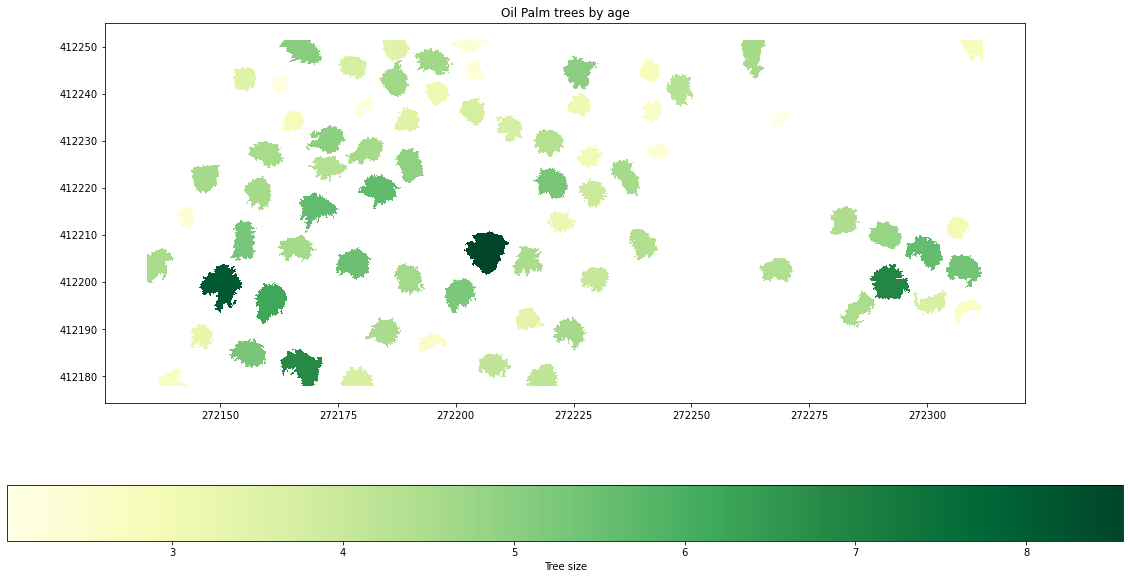

In [120]:

canopy_trees.plot('age',legend=True, legend_kwds={'label': "Tree size", 'orientation': "horizontal"}, figsize=(20,10), cmap='YlGn')
plt.title('Oil Palm trees by age')
plt.show()

plt.savefig('tree_by_age.jpg')